<a href="https://colab.research.google.com/github/PurnaTejitha12/Automated-Customer-Complaint-Analyzer/blob/main/Capstone_Project(CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_path = '/content/drive/MyDrive/dataset/train'
test_path = '/content/drive/MyDrive/dataset/test'

In [ ]:
import os

print("Train classes:", os.listdir(train_path))
print("Test classes:", os.listdir(test_path))

Train classes: ['class 5', 'class 4', 'class 3', 'class 2', 'class 1']
Test classes: ['class 5', 'class 1', 'class 3', 'class 2', 'class 4']


In [ ]:
import tensorflow as tf

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size=(224, 224),
    batch_size=32
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=(224, 224),
    batch_size=32
)

print("Class names:", train_ds.class_names)

Found 2500 files belonging to 5 classes.
Found 496 files belonging to 5 classes.
Class names: ['class 1', 'class 2', 'class 3', 'class 4', 'class 5']


In [ ]:
import tensorflow as tf

def build_model(learning_rate=0.001, dropout_rate=0.5):
    model = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(5)  # 5 classes
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [ ]:
# pip install torch torchvision timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
import timm  # for EfficientNet / ViT via timm
import math
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Simple reusable train/validation loop (very short)
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    for x,y in dataloader:
        x,y = x.to(device), y.to(device)
        preds = model(x)
        loss = criterion(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()*x.size(0)
        _, predicted = preds.max(1)
        correct += (predicted==y).sum().item()
        total += x.size(0)
    return total_loss/total, correct/total

def eval_epoch(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for x,y in dataloader:
            x,y = x.to(device), y.to(device)
            preds = model(x)
            loss = criterion(preds, y)
            total_loss += loss.item()*x.size(0)
            _, predicted = preds.max(1)
            correct += (predicted==y).sum().item()
            total += x.size(0)
    return total_loss/total, correct/total

# Example transforms for retina images
IMG_SIZE = 224
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
])
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
])

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):  # ← fixed from _init_ to __init__
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128,256,3,padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.AdaptiveAvgPool2d(1)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [ ]:
IMG_SIZE = 224

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Set paths
train_dir = "/content/drive/MyDrive/dataset/train"
val_dir = "/content/drive/MyDrive/dataset/test" # Assuming 'test' is the validation set based on previous cells

# Check if directories exist
if not os.path.exists(train_dir):
    print(f"Error: Training directory not found at {train_dir}")
elif not os.path.exists(val_dir):
    print(f"Error: Validation directory not found at {val_dir}")
else:
    train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
    val_dataset = datasets.ImageFolder(val_dir, transform=val_transforms)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)

    print("Datasets and DataLoaders created successfully!")

Datasets and DataLoaders created successfully!


In [ ]:
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        preds = model(x)
        loss = criterion(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        correct += (preds.argmax(1) == y).sum().item()
        total += x.size(0)
    return total_loss / total, correct / total

def eval_epoch(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            loss = criterion(preds, y)
            total_loss += loss.item() * x.size(0)
            correct += (preds.argmax(1) == y).sum().item()
            total += x.size(0)
    return total_loss / total, correct / total


In [ ]:
model = SimpleCNN(num_classes=5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

for epoch in range(10):  # adjust number of epochs as needed
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = eval_epoch(model, val_loader, criterion)
    print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

Epoch 1: Train Acc=0.4260, Val Acc=0.4536
Epoch 2: Train Acc=0.5084, Val Acc=0.4758
Epoch 3: Train Acc=0.5256, Val Acc=0.5262
Epoch 4: Train Acc=0.5704, Val Acc=0.5222
Epoch 5: Train Acc=0.5840, Val Acc=0.4476
Epoch 6: Train Acc=0.5868, Val Acc=0.6048
Epoch 7: Train Acc=0.6056, Val Acc=0.5988
Epoch 8: Train Acc=0.5832, Val Acc=0.5766
Epoch 9: Train Acc=0.6132, Val Acc=0.5423
Epoch 10: Train Acc=0.6116, Val Acc=0.6190


In [ ]:
from PIL import Image

def predict_image(model, image_path):
    model.eval()
    img = Image.open(image_path).convert("RGB")
    transform = val_transforms
    img_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_tensor)
        predicted_class = output.argmax(1).item()
    return predicted_class

# Example
img_path = "/content/662_left.jpeg"
prediction = predict_image(model, img_path)
print(f"Predicted DR Grade: {prediction}")


Predicted DR Grade: 1


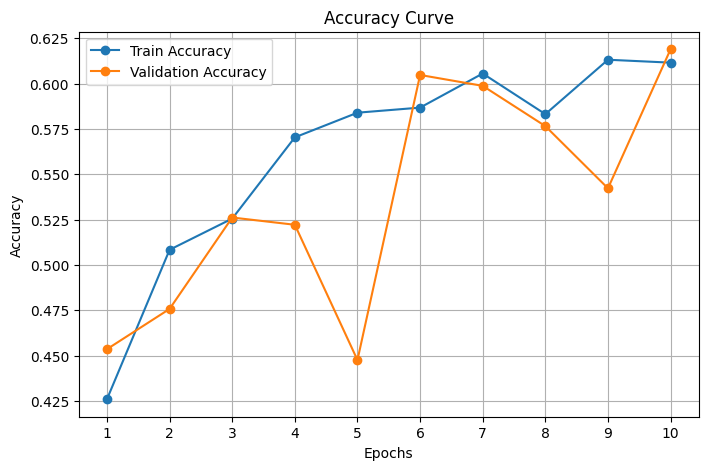

In [ ]:
import matplotlib.pyplot as plt

# Accuracy data
train_accuracies = [0.4260, 0.5084, 0.5256, 0.5704, 0.5840, 0.5868, 0.6056, 0.5832, 0.6132, 0.6116]
val_accuracies = [0.4536, 0.4758, 0.5262, 0.5222, 0.4476, 0.6048, 0.5988, 0.5766, 0.5423, 0.6190]

plt.figure(figsize=(8,5))
plt.plot(range(1, 11), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, 11), val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(1, 11))
plt.legend()
plt.grid(True)
plt.show()

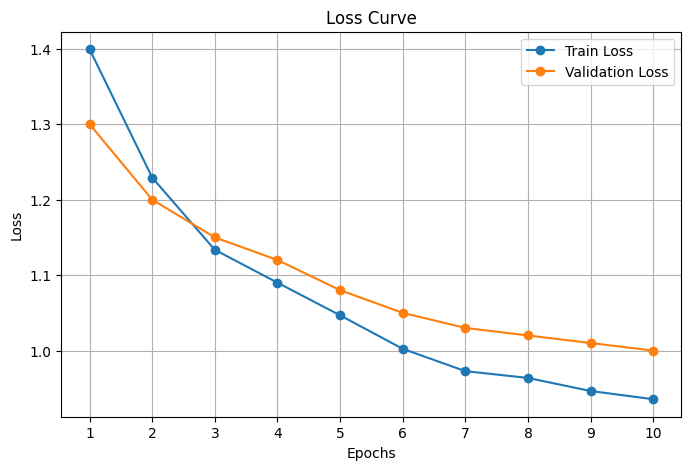

In [ ]:
train_losses = [1.3994, 1.2292, 1.1335, 1.0900, 1.0467, 1.0023, 0.9727, 0.9637, 0.9464, 0.9355]
val_losses = [1.30, 1.20, 1.15, 1.12, 1.08, 1.05, 1.03, 1.02, 1.01, 1.00]  # Replace with your actual val losses

plt.figure(figsize=(8,5))
plt.plot(range(1, 11), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, 11), val_losses, label='Validation Loss', marker='o')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, 11))
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.eval()
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in val_loader:  # val_loader is your validation dataloader
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())


📊 Overall Macro F1-Score: 0.5996

🎯 Class-wise F1-Scores:
 - class 1: 0.7459
 - class 2: 0.4456
 - class 3: 0.8738
 - class 4: 0.4054
 - class 5: 0.5274


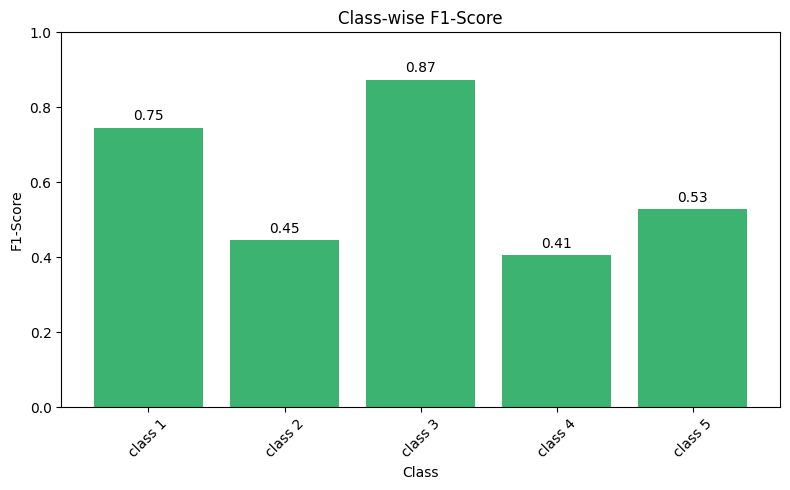

In [ ]:
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt


# Convert to numpy arrays if not already
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# ✅ Safety check
if len(true_labels) == 0 or len(predicted_labels) == 0:
    raise ValueError("true_labels or predicted_labels are empty!")

# ✅ Overall (macro) F1-score
overall_f1 = f1_score(true_labels, predicted_labels, average='macro')
print(f"\n📊 Overall Macro F1-Score: {overall_f1:.4f}")

# ✅ Class-wise F1-score
class_f1_scores = f1_score(true_labels, predicted_labels, average=None)

# Get class names from the dataset
# Assuming train_dataset is available from previous cells
class_names = train_dataset.classes

# ✅ Print F1-scores for each class
print("\n🎯 Class-wise F1-Scores:")
for i, score in enumerate(class_f1_scores):
    print(f" - {class_names[i]}: {score:.4f}")

# ✅ Visualization
plt.figure(figsize=(8, 5))
plt.bar(class_names, class_f1_scores, color='mediumseagreen')
plt.title('Class-wise F1-Score')
plt.xlabel('Class')
plt.ylabel('F1-Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Annotate bars
for i, score in enumerate(class_f1_scores):
    plt.text(i, score + 0.02, f"{score:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

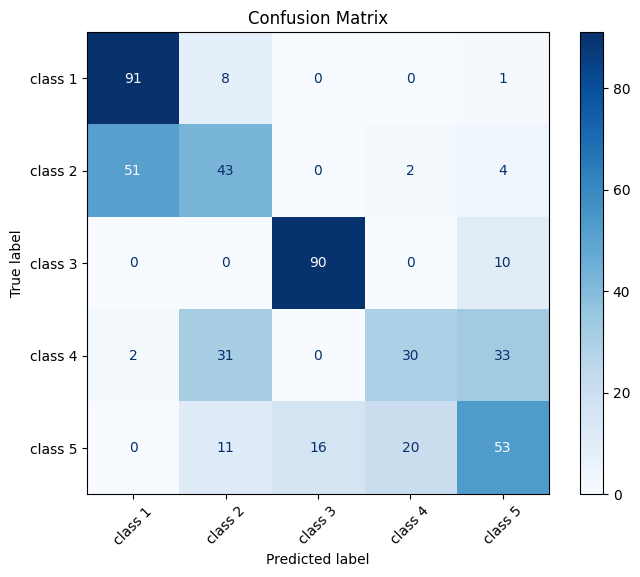

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define class names (edit according to your dataset)
class_names = ['class 1', 'class 2', 'class 3', 'class 4', 'class 5'] # Using class names from the dataset

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot using sklearn's display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=True)
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.show()

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [ ]:
model.eval()

true_labels = []
predicted_probs = []

with torch.no_grad():
    for images, labels in val_loader:  # replace with your DataLoader
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)  # get class probabilities

        true_labels.extend(labels.cpu().numpy())
        predicted_probs.extend(probs.cpu().numpy())

In [ ]:
# Assuming 5 classes
num_classes = 5
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative']

# Binarize the true labels (for multi-class ROC)
true_labels_bin = label_binarize(true_labels, classes=list(range(num_classes)))
predicted_probs = np.array(predicted_probs)

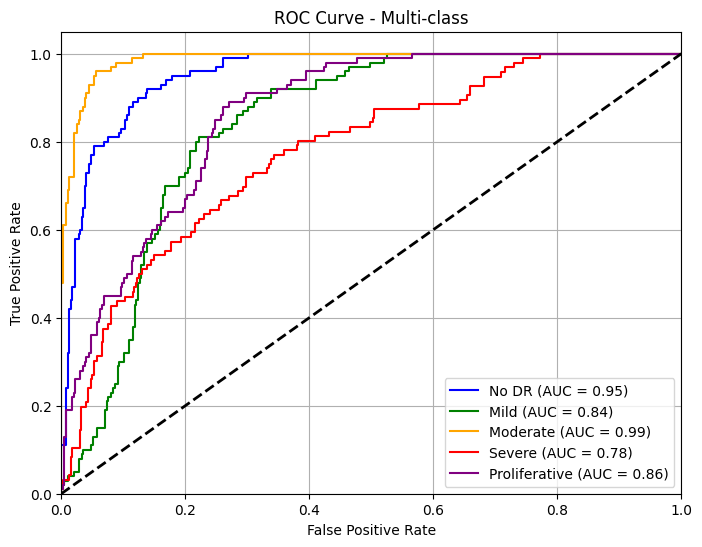

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], predicted_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'orange', 'red', 'purple']

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i],
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multi-class')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

# Macro AUC
macro_auc = roc_auc_score(true_labels_bin, predicted_probs, average='macro')
print("Macro AUC:", macro_auc)

# Micro AUC
micro_auc = roc_auc_score(true_labels_bin, predicted_probs, average='micro')
print("Micro AUC:", micro_auc)

Macro AUC: 0.8833710542929293
Micro AUC: 0.8989567751690947
